<a href="https://colab.research.google.com/github/talaabusoud/adult-income-ml/blob/main/Project4_Part1_Core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adult income pridiction:
- Author: Tala AbuSoud

* **Dataset:**
[Adult income dataset
](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset)

# *Part 1*

# **Loading data**

In [4]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.compose import make_column_transformer, ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, \
ConfusionMatrixDisplay, accuracy_score, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import missingno as msno
from imblearn.pipeline import make_pipeline as make_sampler_pipeline

In [5]:
fpath = '/content/drive/MyDrive/AXSOSACADEMY/AXSOSACADEMY/05-IntermediateML/Week18/Data/adult.csv'
df = pd.read_csv(fpath)
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [6]:
df.shape

(48842, 15)

* **Target:** the target here is to predict the `income`, whether a person earns >50K or <=50K per year.

* One row in the dataset represent **One individual person** with demographic and work-related attributes.


* It contains **14 features** to predict the target, and **48842 rows**

# **1) Data Cleaning**

## 1.a: Checking for nulls

In [7]:
df.isna().sum().sum()

np.int64(0)

There is no missing values in the dataset

## 1.b: Checking Data Types

In [8]:
df.dtypes

,0
age,int64
workclass,object
fnlwgt,int64
education,object
educational-num,int64
marital-status,object
occupation,object
relationship,object
race,object
gender,object


## 1.c: Checking inconsistent values in categorical features

In [9]:
inc_col=df.select_dtypes('object')
# loop through the list of string columns
for col in inc_col:
  print(f'Value For {col} column is: ')
  print(df[col].value_counts())
  print('\n')

Value For workclass column is: 
workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64


Value For education column is: 
education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64


Value For marital-status column is: 
marital-status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name:

In [10]:
cols = ["occupation", "native-country", "workclass"]
df[cols] = df[cols].replace("?", np.nan)

In [11]:
df[cols].isna().sum()

,0
occupation,2809
native-country,857
workclass,2799


We will impute the nulls later in preprocessing stage

In [12]:
df["income"] = df["income"].map({"<=50K": 0, ">50K": 1})
df["income"] = df["income"].astype(int)
df["income"].value_counts()

,count
income,
0,37155
1,11687


We changed the income into 1 and 0, because its easier to deal with

1: >50K

0: <=50K

In [13]:
df = df.drop(columns="education")

since we have `education_num` and its the same as `education` but clearer and easier to deal with so we drop it

## 1.d: Checking impossible values in numeric columns

In [14]:
df.describe().round(3)

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income
count,48842.000,48842.000,48842.000,48842.000,48842.000,48842.000,48842.000
mean,38.644,189664.135,10.078,1079.068,87.502,40.422,0.239
std,13.711,105604.025,2.571,7452.019,403.005,12.391,0.427
min,17.000,12285.000,1.000,0.000,0.000,1.000,0.000
25%,28.000,117550.500,9.000,0.000,0.000,40.000,0.000
50%,37.000,178144.500,10.000,0.000,0.000,40.000,0.000
75%,48.000,237642.000,12.000,0.000,0.000,45.000,0.000
max,90.000,1490400.000,16.000,99999.000,4356.000,99.000,1.000


- `capital-gain` and `capital-loss` columns are highly skewed; most rows are 0.

- `fnlwgt` is not useful so we wil drop it.

- `hours-per-week` max value is 99 its extreme value but we can't drop it as it could be real, but logically the 80h/w is the max

In [15]:
df = df.drop(columns="fnlwgt")

In [16]:
# Show all columns for rows where hours-per-week = 99
(df["hours-per-week"] == 99).sum()

np.int64(137)

There is 137 person with 99 working hours per week

In [17]:
((df["hours-per-week"] < 1) | (df["hours-per-week"] > 80)).sum()

np.int64(318)

And there is 318 ones with more than 80 hours of work per week

## 1.e: Checking for duplicates

In [18]:
df.duplicated().sum()

np.int64(6374)

* There is 6374 rows that are duplicated

In [19]:
dup = df.duplicated(keep=False)
df[dup].sort_values(by=df.columns.tolist())

,age,workclass,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
30474,17,Private,5,Never-married,Other-service,Own-child,White,Female,0,0,20,United-States,0
37206,17,Private,5,Never-married,Other-service,Own-child,White,Female,0,0,20,United-States,0
2048,17,Private,6,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,15,United-States,0
13378,17,Private,6,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,15,United-States,0
33976,17,Private,6,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,20,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45400,73,NaN,9,Widowed,NaN,Not-in-family,White,Female,0,0,15,United-States,0
35770,90,Private,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,0
47311,90,Private,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,0
18584,90,Private,10,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,35,United-States,0


In [20]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

## 1.f: Checking the cardinality of categorical features

In [21]:
cat = df.select_dtypes('object').columns
df[cat].describe()

,workclass,marital-status,occupation,relationship,race,gender,native-country
count,40057,42468,40047,42468,42468,42468,41615
unique,8,7,14,6,5,2,41
top,Private,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,28312,19215,5679,16641,35541,27988,37492


- Most features are Low cardinality (less than 10)
- `occupation` is Moderate cardinality, but still okay.
- `native-country` has high cardinality (41 unique values) with many rare countries, we could group the rare categories into "Other".

In [22]:
vc = df["native-country"].value_counts()
rare = vc[vc < 100].index
df["native-country"] = df["native-country"].replace(rare, "Other")
df["native-country"].value_counts()

,count
native-country,
United-States,37492
Other,1210
Mexico,927
Philippines,293
Germany,206
Puerto-Rico,184
Canada,182
El-Salvador,155
India,151


Now we could consider `native-country` as moderate cardinality

# **2) Exploring data**

* Define EDA classifications functions

In [23]:
#EDA1 - categorical_vs_target
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

########################################
# EDA1 - numeric_vs_target
def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                           target_type='reg', estimator='mean',
                           errorbar='ci',sorted=False,ascending=False,
                           **kwargs): # kwargs for sns.regplot

  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if 'reg' in target_type:
    # Calculate the correlation
    corr = df[[x,y]].corr().round(2)
    r = corr.loc[x,y]
    # Plot the data
    scatter_kws={'edgecolor':'white','linewidths':1,'alpha':0.8}
    sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
    ## Add the title with the correlation
    ax.set_title(f"{x} vs. {y} (r = {r})")

  # CLASSIFICATION-TARGET PLOT
  elif 'class' in target_type:

    # Sort the groups by median/mean
    if sorted == True:

      if estimator == 'median':
        group_vals = temp_df.groupby(y)[x].median()
      elif estimator =='mean':
        group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
      group_vals = group_vals.sort_values(ascending=ascending)
      order = group_vals.index

    else:
      # Set order to None if not calcualted
      order = None


    # Left Subplot (barplot)
    sns.barplot(data=temp_df, x=y, y=x, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)

    # Add title
    ax.set_title(f"{x} vs. {y}")

    # rotate xaxis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax

## 2.a: Categroical vs Target

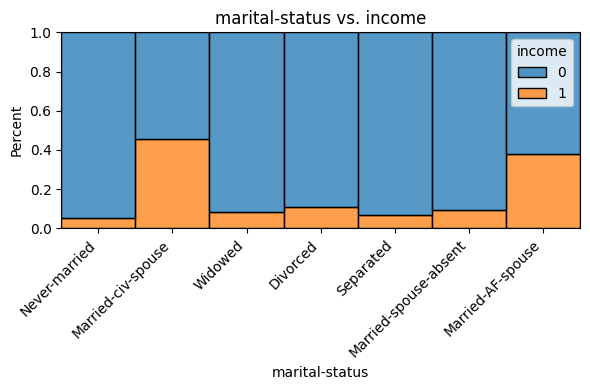

In [24]:
plot_categorical_vs_target(df, 'marital-status', 'income', target_type='class');

- Married individuals, especially Married-civ-spouse and Married-AF-spouse, have a much higher proportion of people with higher income (income = 1).

- Those who are Never-married, Widowed, Divorced, Separated, or Married-spouse-absent are more likely to fall in the lower-income category (income = 0).

- This indicates that being married (particularly with a spouse present) is strongly associated with higher income levels.

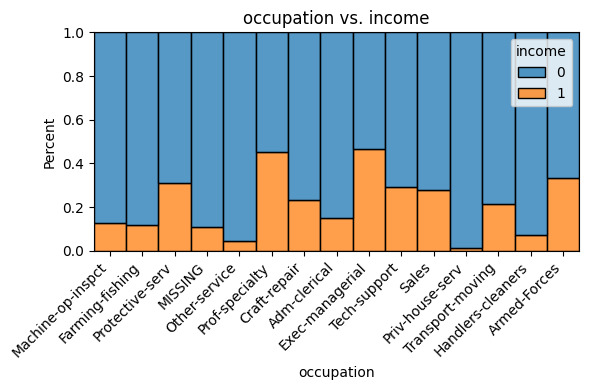

In [25]:
plot_categorical_vs_target(df, 'occupation', 'income', target_type='class');

- Most occupations are dominated by low-income individuals.
- Exec-managerial, Prof-specialty, and Tech-support have the highest share of high-income earners.
- Service and manual labor roles (e.g., Other-service, Farming, Handlers-cleaners) show the lowest.
- Thus, income is strongly tied to occupation type.

## 2.b: Numaric vs Target

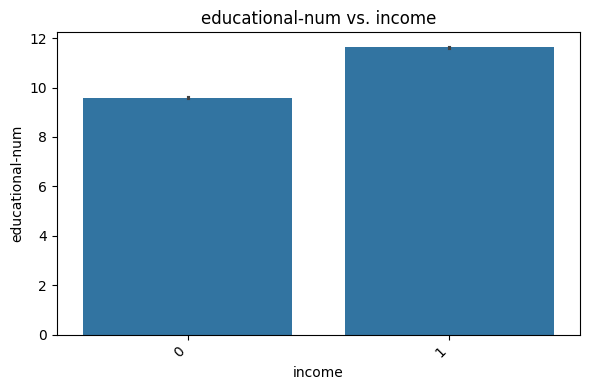

In [26]:
plot_numeric_vs_target(df, x='educational-num', y='income', target_type='class', errorbar='se');

The chart shows that individuals with higher income (income = 1) tend to have a significantly higher average educational-num (≈11.7) compared to those with lower income (income = 0, ≈9.6). This suggests that higher levels of education are strongly associated with higher income, reinforcing the idea that education is a key factor in determining earning potential.

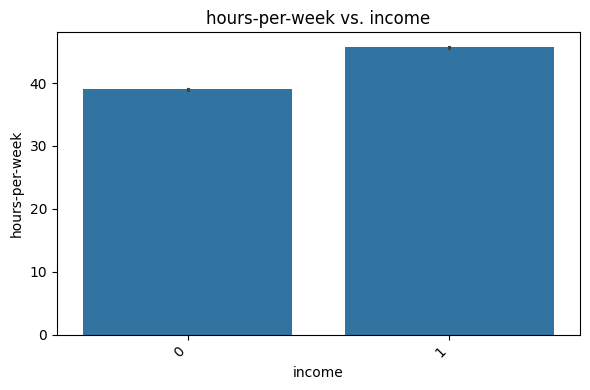

In [27]:
plot_numeric_vs_target(df, x='hours-per-week', y='income', target_type='class', errorbar='se');

The chart shows that individuals with higher income (income = 1) tend to have higher number of working hours per week (≈45) compared to those with lower income (income = 0, ≈40). This suggests that more hours of work per week are strongly associated with higher income, reinforcing the idea that working more hours in a week is a key factor in determining earning potential.

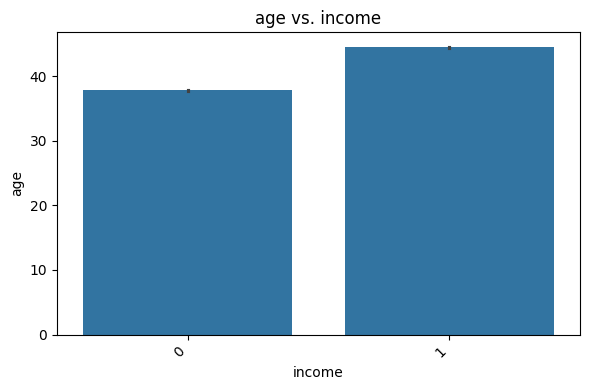

In [28]:
plot_numeric_vs_target(df, x='age', y='income', target_type='class', errorbar='se');

The chart shows that individuals with higher income (income = 1) tend to have a significantly higher average age (≈44) compared to those with lower income (income = 0, ≈38). This suggests that older ages are strongly associated with higher income.

## 2.c: Heatmap

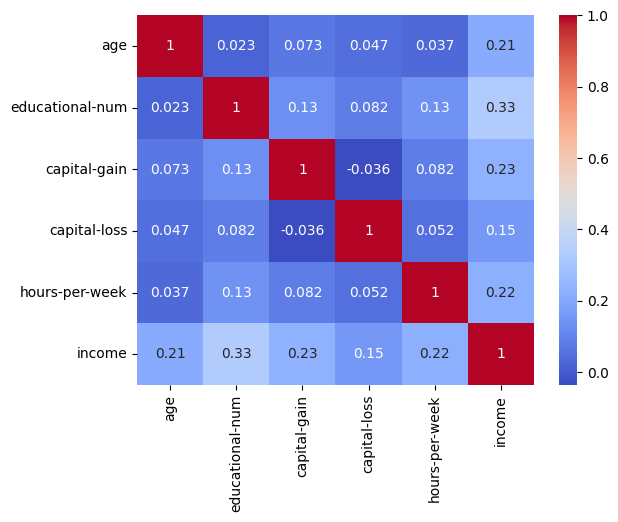

In [29]:
corr = df.corr(numeric_only = True)
ax = sns.heatmap(corr, cmap = 'coolwarm', annot = True);

- `Educational-num` has the strongest positive correlation with `income` (0.33). → Higher education generally leads to higher income.

- `Capital-gain` (0.23) and `hours-per-week` (0.22) also show moderate positive correlations with `income`. → People who work more hours or have capital gains are more likely to earn higher income.

- `Age` has a weaker correlation with `income` (0.21). → Older individuals tend to earn more, but the effect is smaller compared to education and capital gain.

- `Capital-loss` has the weakest correlation with `income` (0.15).

Overall, education, working hours, and financial capital (gains/losses) play a stronger role in predicting income than age.

# **3) Preprocessing**

In [30]:
# cheack for class balance
df['income'].value_counts(normalize=True)

,proportion
income,
0,0.753979
1,0.246021


* The data is imbalanced, so we will use smote

In [31]:
# Make X and y
y = df['income']
X = df.drop(columns=['income'])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31851 entries, 22814 to 16878
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              31851 non-null  int64 
 1   workclass        30038 non-null  object
 2   educational-num  31851 non-null  int64 
 3   marital-status   31851 non-null  object
 4   occupation       30029 non-null  object
 5   relationship     31851 non-null  object
 6   race             31851 non-null  object
 7   gender           31851 non-null  object
 8   capital-gain     31851 non-null  int64 
 9   capital-loss     31851 non-null  int64 
 10  hours-per-week   31851 non-null  int64 
 11  native-country   31212 non-null  object
dtypes: int64(5), object(7)
memory usage: 3.2+ MB


## Categorical features

In [33]:
# define categorical features
cat_cols = X_train.select_dtypes("object").columns

# impute nulls with MISSING
impute_missing = SimpleImputer(strategy='constant',fill_value='MISSING')

# one hot encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# instantiate the pipeline
cat_pipe = make_pipeline(impute_missing, ohe)

# make a tuple for column transformer
cat_tuple = ('nominal',cat_pipe, cat_cols)
cat_tuple

('nominal',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='MISSING', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
        'gender', 'native-country'],
       dtype='object'))

## Numerical features

In [34]:
# define numerical features
num_cols = X_train.select_dtypes("number").columns

# scaling
scaler = StandardScaler()

# make the tuple for ColumnTransformer
num_tuple = ('numeric',scaler, num_cols)
num_tuple

('numeric',
 StandardScaler(),
 Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
        'hours-per-week'],
       dtype='object'))

In [35]:
df.isna().sum()

,0
age,0
workclass,2411
educational-num,0
marital-status,0
occupation,2421
relationship,0
race,0
gender,0
capital-gain,0
capital-loss,0


## Instantiate the ColumnTransformer

In [36]:
# Instantiate with verbose_feature_names_out=False
preprocessor = ColumnTransformer([cat_tuple, num_tuple],
                                    verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('nominal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender', 'native-country'],
      dtype='object')),
                                ('numeric', StandardScaler(),
                                 Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [37]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_prep, y_train)

# **4) Modeling**

In [38]:
# Difine Classification Evaluation Functions
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## **4.1: Random Forest Classifier**

### 4.1.a: Default RF Model

In [39]:
# Make an instance of the model
rf = RandomForestClassifier(random_state=42)

# Training the model on the data, storing the information learned from the data
# Model is learning the relationship between X and y
rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     24059
           1       0.98      0.99      0.99     24059

    accuracy                           0.99     48118
   macro avg       0.99      0.99      0.99     48118
weighted avg       0.99      0.99      0.99     48118



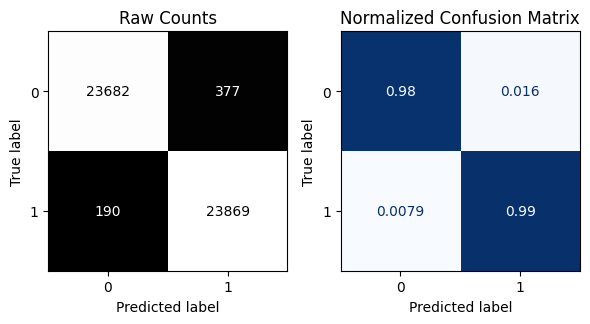


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      7961
           1       0.66      0.63      0.64      2656

    accuracy                           0.82     10617
   macro avg       0.77      0.76      0.76     10617
weighted avg       0.82      0.82      0.82     10617



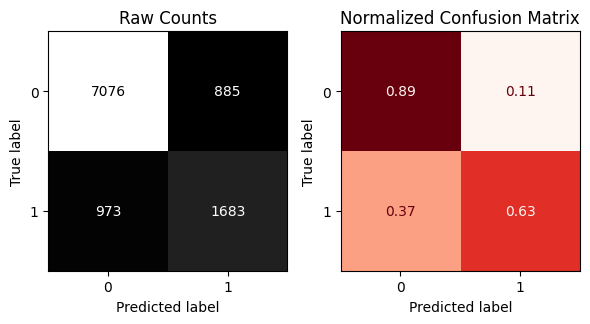

In [40]:
evaluate_classification(rf, X_train_smote, y_train_smote, X_test_prep, y_test)

The model achieved very high performance on the training data, with an accuracy of 99% and F1-scores of 0.99 for both income classes (overfitting). While on the test data, the performance dropped to 82% accuracy, with a notable difference between classes: the model predicted the majority class (≤50K) well, but struggled with the minority class (>50K), achieving an F1-score of only 0.64.

### 4.1.b: Hyperparameter Tuning using GridSearchCV

In [41]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [46]:
param_grid = {
    'n_estimators': [50, 100, 500],
    'max_depth': [5, 15, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 10],
    'max_features': ['sqrt', 'log2']
}

gs_rf = GridSearchCV(rf, param_grid, verbose=True, n_jobs=2, cv=3,
                  return_train_score=True,scoring='recall_macro')

gs_rf.fit(X_train_smote, y_train_smote)
print(f'Best Params: {gs_rf.best_params_}')

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     24059
           1       0.94      0.99      0.96     24059

    accuracy                           0.96     48118
   macro avg       0.96      0.96      0.96     48118
weighted avg       0.96      0.96      0.96     48118



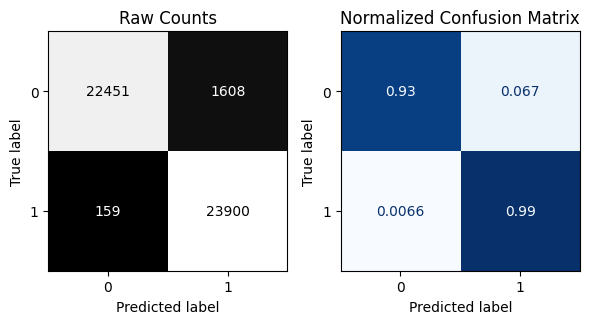


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      7961
           1       0.65      0.74      0.70      2656

    accuracy                           0.84     10617
   macro avg       0.78      0.81      0.79     10617
weighted avg       0.85      0.84      0.84     10617



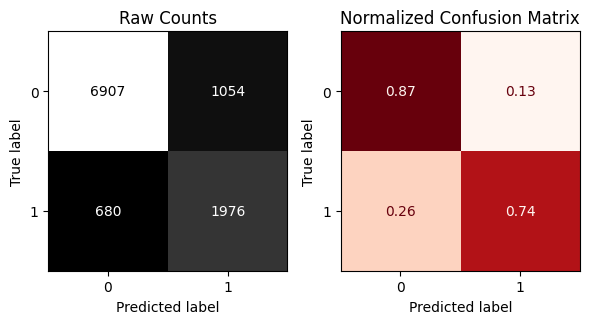

In [47]:
best_rf = gs_rf.best_estimator_
evaluate_classification(best_rf, X_train_smote, y_train_smote, X_test_prep, y_test)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     24059
           1       0.94      0.99      0.96     24059

    accuracy                           0.96     48118
   macro avg       0.96      0.96      0.96     48118
weighted avg       0.96      0.96      0.96     48118



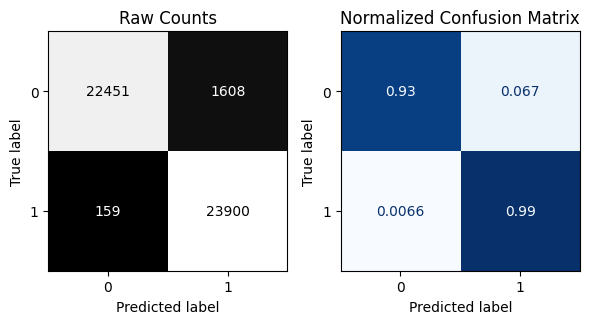


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      7961
           1       0.65      0.74      0.70      2656

    accuracy                           0.84     10617
   macro avg       0.78      0.81      0.79     10617
weighted avg       0.85      0.84      0.84     10617



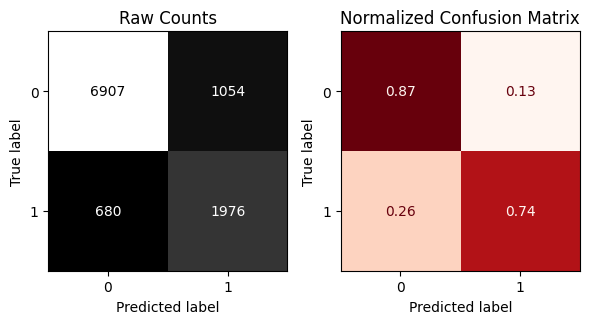

In [45]:
# Create a new RandomForestClassifier with best params
rf_best = RandomForestClassifier(
    n_estimators=500,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

# Fit on the resampled training data
rf_best.fit(X_train_smote, y_train_smote)

# Evaluate
evaluate_classification(rf_best, X_train_smote, y_train_smote, X_test_prep, y_test)


After hyperparameter tuning, the model showed clear improvement in generalization. While the training accuracy decreased slightly from 99% to 96%, this reduction helped reduce overfitting. On the test set, accuracy increased from 82% to 84%, and recall for the minority class (income >50K) improved significantly from 63% to 74%, leading to a higher F1-score (0.70 compared to 0.64 before tuning).

## **4.2: ROC Curves**

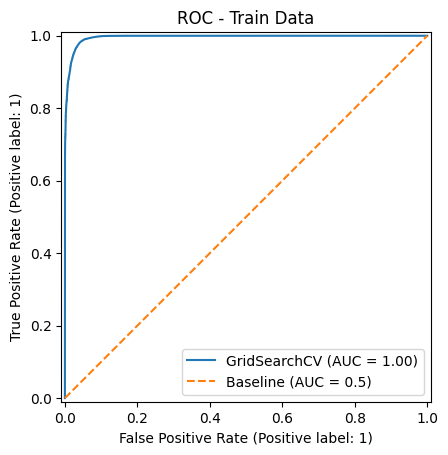

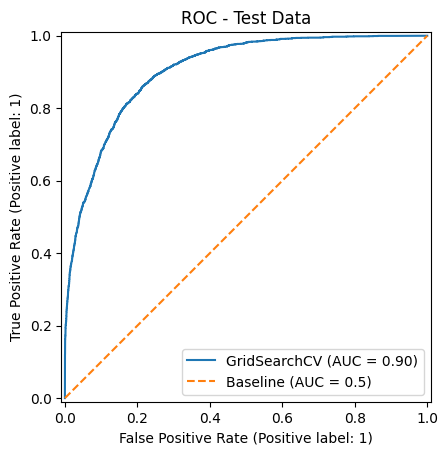

In [48]:
# Visualize the ROC curve
RocCurveDisplay.from_estimator(gs_rf, X_train_smote, y_train_smote)
plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
plt.legend();
plt.title("ROC - Train Data");

RocCurveDisplay.from_estimator(gs_rf, X_test_prep, y_test)
plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
plt.legend();
plt.title("ROC - Test Data");

# **5) Permutation Importance**

In [59]:
feature_names = preprocessor.get_feature_names_out()

feature_importance = pd.Series(best_rf.feature_importances_, index=feature_names,
                        name='Feature Importances')
feature_importance.head(10)

,Feature Importances
workclass_Federal-gov,0.004244
workclass_Local-gov,0.005275
workclass_MISSING,0.001753
workclass_Never-worked,0.000005
workclass_Private,0.010575
workclass_Self-emp-inc,0.004918
workclass_Self-emp-not-inc,0.007941
workclass_State-gov,0.004430
workclass_Without-pay,0.000133
marital-status_Divorced,0.011681


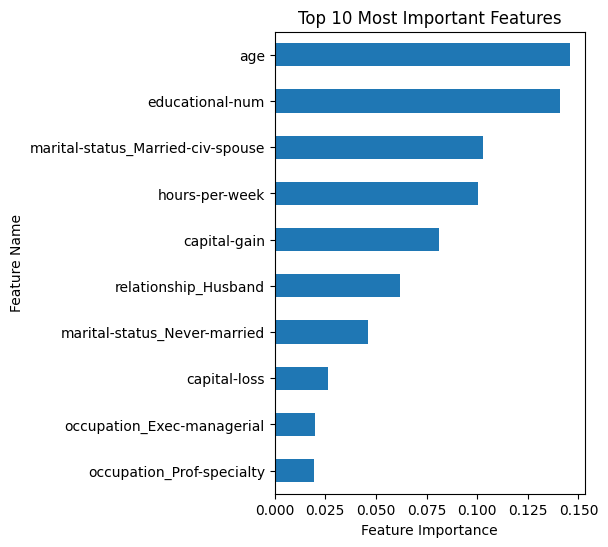

In [60]:
ax = feature_importance.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Feature Importance',
       title='Top 10 Most Important Features');

In [64]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_rf, X_train_smote, y_train_smote ,n_repeats =50, random_state = 42)
result.keys()

KeyboardInterrupt: 

In [ ]:
## can make the mean importances into a series
perm_importances = pd.Series(result['importances_mean'],index=X_train_smote.columns,
                           name = 'permutation importance')
perm_importances.head()

In [ ]:
ax = perm_importances.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Permutation Importance',
       title='Top 10 Most Important Features: Permutation Importance');

**The top 10 features:**
- Age
- Educational-num
-
-
-
-
-
-
-
-

**Do these features make sense based on the business case?**


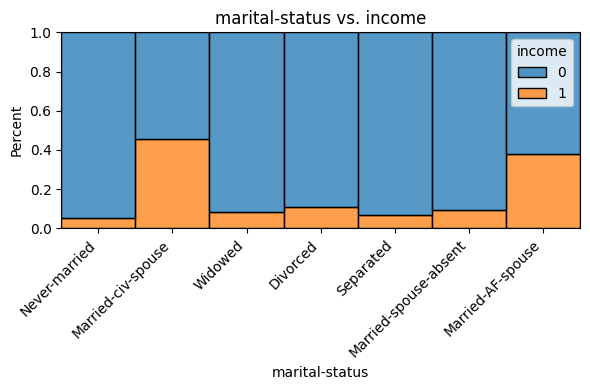

In [ ]:
plot_categorical_vs_target(df, 'marital-status', 'income', target_type='class');

- Married individuals, especially Married-civ-spouse and Married-AF-spouse, have a much higher proportion of people with higher income (income = 1).

- Those who are Never-married, Widowed, Divorced, Separated, or Married-spouse-absent are more likely to fall in the lower-income category (income = 0).

- This indicates that being married (particularly with a spouse present) is strongly associated with higher income levels.

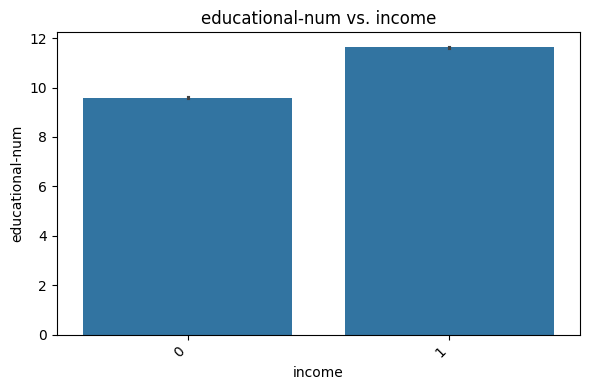

In [ ]:
plot_numeric_vs_target(df, x='educational-num', y='income', target_type='class', errorbar='se');

The chart shows that individuals with higher income (income = 1) tend to have a significantly higher average educational-num (≈11.7) compared to those with lower income (income = 0, ≈9.6). This suggests that higher levels of education are strongly associated with higher income, reinforcing the idea that education is a key factor in determining earning potential.